# RNN Model for Dopamine Level Prediction

This notebook implements a neural network to predict dopamine levels based on red PWM and blue PWM inputs using PyTorch.


## Step 1: Import Necessary Libraries


In [1]:
import socket
print("Jupyter is running on:", socket.gethostname())

import torch
print(torch.cuda.is_available())

Jupyter is running on: holygpu8a19404.rc.fas.harvard.edu
True


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import tqdm


## Step 2-3: Done on local

Local dataset loads and reads faster


## Step 4: Split into Training and Testing Sets


In [3]:
# Load directly from saved data

save_dir = "/n/holylabs/LABS/bsabatini_lab/Users/shunnnli/BrainClamp/Data/TCN-dataset/dataset-200ms-100ms/"

# Load the dataset
X, y = [], []
for file_name in os.listdir(save_dir):
    data = np.load(os.path.join(save_dir, file_name))
    X.append(torch.from_numpy(data['X']).float())
    y.append(torch.from_numpy(data['y']).float())
X = torch.cat(X, dim=0)
y = torch.cat(y, dim=0)
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_train_laser = y_train[:,:,:2]
y_test_laser = y_test[:,:,:2]
y_train = y_train[:, :, -1]
y_test = y_test[:, :, -1]


print("Data Splitting:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_train_laser shape: {y_train_laser.shape}")
print(f"y_test_laser shape: {y_test_laser.shape}")

# Build dataset with dataloader
from torch.utils.data import TensorDataset, DataLoader
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


Data Splitting:
X_train shape: torch.Size([1729, 2000, 3])
y_train shape: torch.Size([1729, 1000])
X_test shape: torch.Size([433, 2000, 3])
y_test shape: torch.Size([433, 1000])
y_train_laser shape: torch.Size([1729, 1000, 2])
y_test_laser shape: torch.Size([433, 1000, 2])


In [ ]:
# Data augmentation

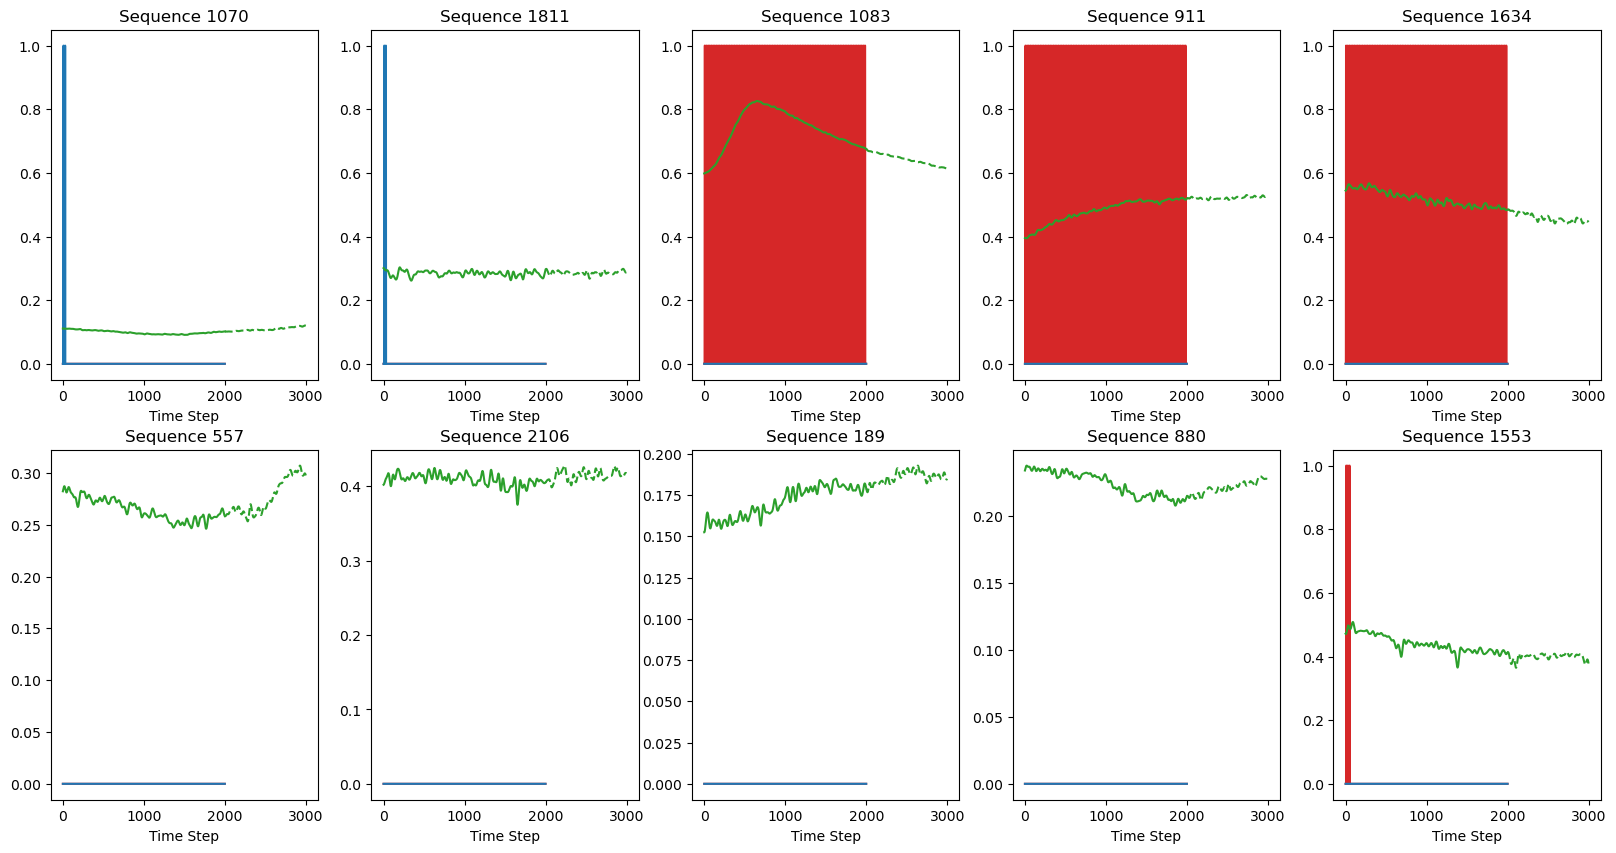

In [4]:
# Plot random 10 sequences with pulse events
pred_time = np.arange(X.shape[1],X.shape[1]+y.shape[1])
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    random_idx = np.random.randint(0, X.shape[0])
    plt.plot(X[random_idx,:,0], color='tab:red')
    plt.plot(X[random_idx,:,1], color='tab:blue')
    plt.plot(X[random_idx,:,2], color='tab:green')
    plt.plot(pred_time, y[random_idx,:,2], color='tab:green', linestyle='--')
    plt.title(f'Sequence {random_idx}')
    plt.xlabel('Time Step')
plt.show()

## Step 5: setup TCN

In [4]:
class Chomp1d(nn.Module):
    """Remove future information by chopping off the right padding"""
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        if self.chomp_size == 0:
            return x
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """Temporal Convolutional Block with causal padding and residual connection"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TCNModel(nn.Module):
    """Temporal Convolutional Network for time series prediction"""
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=2, dropout=0.2, horizon=1000):
        super(TCNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.horizon = horizon
        
        # Calculate the receptive field
        receptive_field = 1
        for i in range(num_layers):
            receptive_field += 2*(kernel_size - 1) * (2 ** i)
        self.receptive_field = receptive_field
        
        # Input projection layer
        # self.input_projection = nn.Linear(input_size, hidden_size)
        self.input_projection = nn.Conv1d(input_size, hidden_size, kernel_size=1) if input_size != hidden_size else None
        
        # Temporal blocks
        layers = []
        num_channels = [hidden_size] * num_layers
        
        for i in range(num_layers):
            dilation_size = 2 ** i
            in_channels = hidden_size if i == 0 else hidden_size
            out_channels = num_channels[i]
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, horizon * output_size)

    def forward(self, x):                    # x: (B, T_hist, F)
        x = x.transpose(1, 2)                # -> (B, F, T_hist)
        if self.input_projection is not None:
            x = self.input_projection(x)
        z = self.network(x)                  # (B, hidden, T_hist)

        h_last = z[:, :, -1]                 # (B, hidden)   <-- last TIME step
        y = self.output_layer(h_last)        # (B, horizon * output_size)
        return y.view(y.size(0), self.horizon, self.output_size)  # (batch, time_step, output_size)

    def weighted_loss(self, pred, target, gamma=0.999, laser_on=None):
        target = target.unsqueeze(-1)

        # Get time points for proximity weight
        T = pred.size(1)
        time_points = torch.arange(T, device=pred.device)
        proximity_weight = (gamma ** time_points).view(1, T, 1)
        
        if laser_on is not None:
            laser_weight = torch.ones_like(pred)
            laser_mask = laser_on.unsqueeze(-1) if laser_on.dim() == 2 else laser_on
            laser_weight = torch.where(laser_mask, 2.0, 1.0)
        else:
            laser_weight = 1.0

        # For each sample, compute elementwise squared error and multiply by proximity_weight (broadcasted over batch if needed)
        seq_loss = ((pred - target) ** 2) * proximity_weight

        weighted_loss = seq_loss * laser_weight
        return weighted_loss.mean()




In [ ]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
        
#         # Define the LSTM layer
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
#         # Define the output layer
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # Initialize hidden and cell states on the correct device
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
#         # Forward propagate LSTM
#         # out: tensor of shape (batch_size, seq_length, hidden_size)
#         out, _ = self.lstm(x, (h0, c0))
        
#         # Apply output layer to each timestep (sequence), as in the TCN
#         out = self.fc(out)  # (batch_size, seq_len, output_size)
#         return out

#     def weighted_loss(self, pred, target, gamma=0.999, laser_on=None):
#         dopamine = target.unsqueeze(-1)
#         seq_len = pred.shape[1] if pred.dim() > 1 else pred.shape[0]
#         time_points = torch.arange(seq_len, device=pred.device)

#         proximity_weight = gamma ** time_points  # 1 for t=0, gamma for t=1, ...
#         proximity_weight = proximity_weight.unsqueeze(0).unsqueeze(-1)
        
#         if laser_on is not None:
#             laser_weight = torch.ones_like(pred)
#             laser_mask = laser_on.unsqueeze(-1) if laser_on.dim() == 2 else laser_on
#             laser_weight = torch.where(laser_mask, 2.0, 1.0)
#         else:
#             laser_weight = 1.0

#         seq_loss = ((pred - dopamine) ** 2) * proximity_weight

#         weighted_loss = seq_loss * laser_weight
#         return weighted_loss.mean()

## Step 6: Build the Model in PyTorch


In [6]:
# Model parameters
input_size = 2000#X_train.shape[2]  # Number of features (3)
hidden_size = 128
num_layers = 8 
output_size = 1
horizon = 1000#y_train.shape[1]

# Create TCN model
tcn_model = TCNModel(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers,
    output_size=output_size, 
    horizon=horizon,
    kernel_size=3,  # TCN kernel size
    dropout=0.2
)

print("TCN Model Architecture:")
print(tcn_model)
print(f"\nTCN Receptive Field: {tcn_model.receptive_field}")
print(f"Input sequence length: {input_size}")
print(f"Hidden size: {hidden_size}")
print(f"Number of layers: {num_layers}")



TCN Model Architecture:
TCNModel(
  (input_projection): Conv1d(2000, 128, kernel_size=(1,), stride=(1,))
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): Chomp1d()
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
        (5): Chomp1d()
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
      )
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
  

In [ ]:
# # Model parameters
# input_size = X_train.shape[2]  # Number of features (3)
# hidden_size = 50
# num_layers = 4 # Corresponds to two stacked LSTM layers
# output_size = 1

# lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob=0.2)
# print("Model Architecture:")
# print(lstm_model)

Model Architecture:
LSTMModel(
  (lstm): LSTM(3, 50, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


## Step 7: Train the Model


In [15]:
model = tcn_model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Move data to the same device as the model
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        outputs = model(batch_X)
        laser_on = torch.any((batch_X[:,:,0] > 0.5) | (batch_X[:,:,1] > 0.5), dim=1)

        # get the last 100ms of the batch
        loss = model.weighted_loss(outputs, batch_y, gamma=0.999, laser_on=laser_on)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_epoch_loss = 0.0
        total_val_samples = 0
        for val_batch_X, val_batch_y in test_loader:
            val_batch_X = val_batch_X.to(device)
            val_batch_y = val_batch_y.to(device)
            val_outputs = model(val_batch_X)
            val_loss = model.weighted_loss(val_outputs, val_batch_y, gamma=0.999)
            val_epoch_loss += val_loss.item() * val_batch_X.size(0)
            total_val_samples += val_batch_X.size(0)
        avg_val_loss = val_epoch_loss / total_val_samples
        val_losses.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {val_loss.item():.4f}')

    del outputs, loss  # any big tensors
    torch.cuda.empty_cache()

print("Training complete.")



Starting model training...
Epoch [5/100], Train Loss: 0.0012, Validation Loss: 0.0003
Epoch [10/100], Train Loss: 0.0008, Validation Loss: 0.0004
Epoch [15/100], Train Loss: 0.0006, Validation Loss: 0.0003
Epoch [20/100], Train Loss: 0.0006, Validation Loss: 0.0002
Epoch [25/100], Train Loss: 0.0006, Validation Loss: 0.0003
Epoch [30/100], Train Loss: 0.0005, Validation Loss: 0.0003
Epoch [35/100], Train Loss: 0.0005, Validation Loss: 0.0003
Epoch [40/100], Train Loss: 0.0005, Validation Loss: 0.0002
Epoch [45/100], Train Loss: 0.0005, Validation Loss: 0.0002
Epoch [50/100], Train Loss: 0.0005, Validation Loss: 0.0002
Epoch [55/100], Train Loss: 0.0004, Validation Loss: 0.0002
Epoch [60/100], Train Loss: 0.0004, Validation Loss: 0.0002
Epoch [65/100], Train Loss: 0.0004, Validation Loss: 0.0002
Epoch [70/100], Train Loss: 0.0004, Validation Loss: 0.0002
Epoch [75/100], Train Loss: 0.0005, Validation Loss: 0.0003
Epoch [80/100], Train Loss: 0.0004, Validation Loss: 0.0007
Epoch [85/100

## Step 8: Evaluate and Visualize the Results


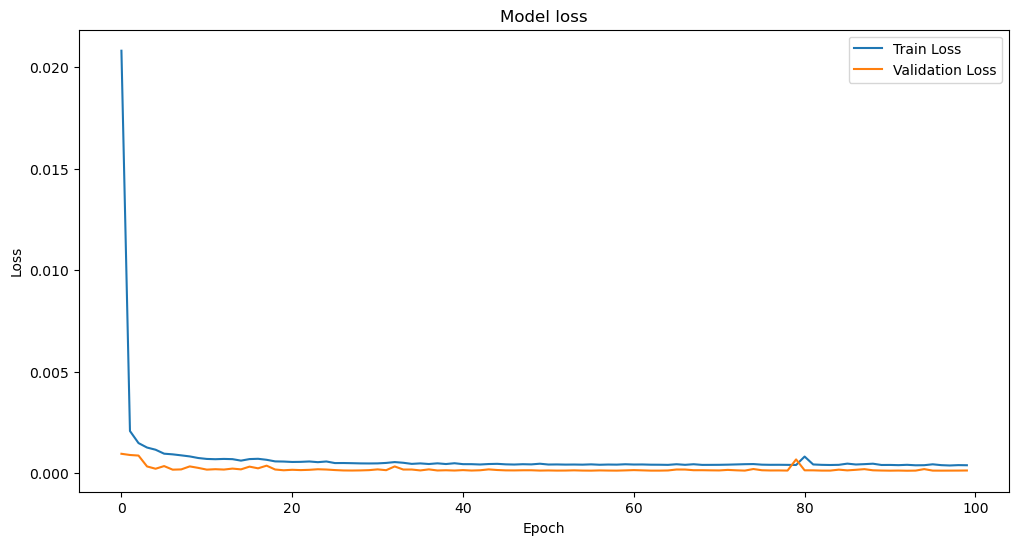

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


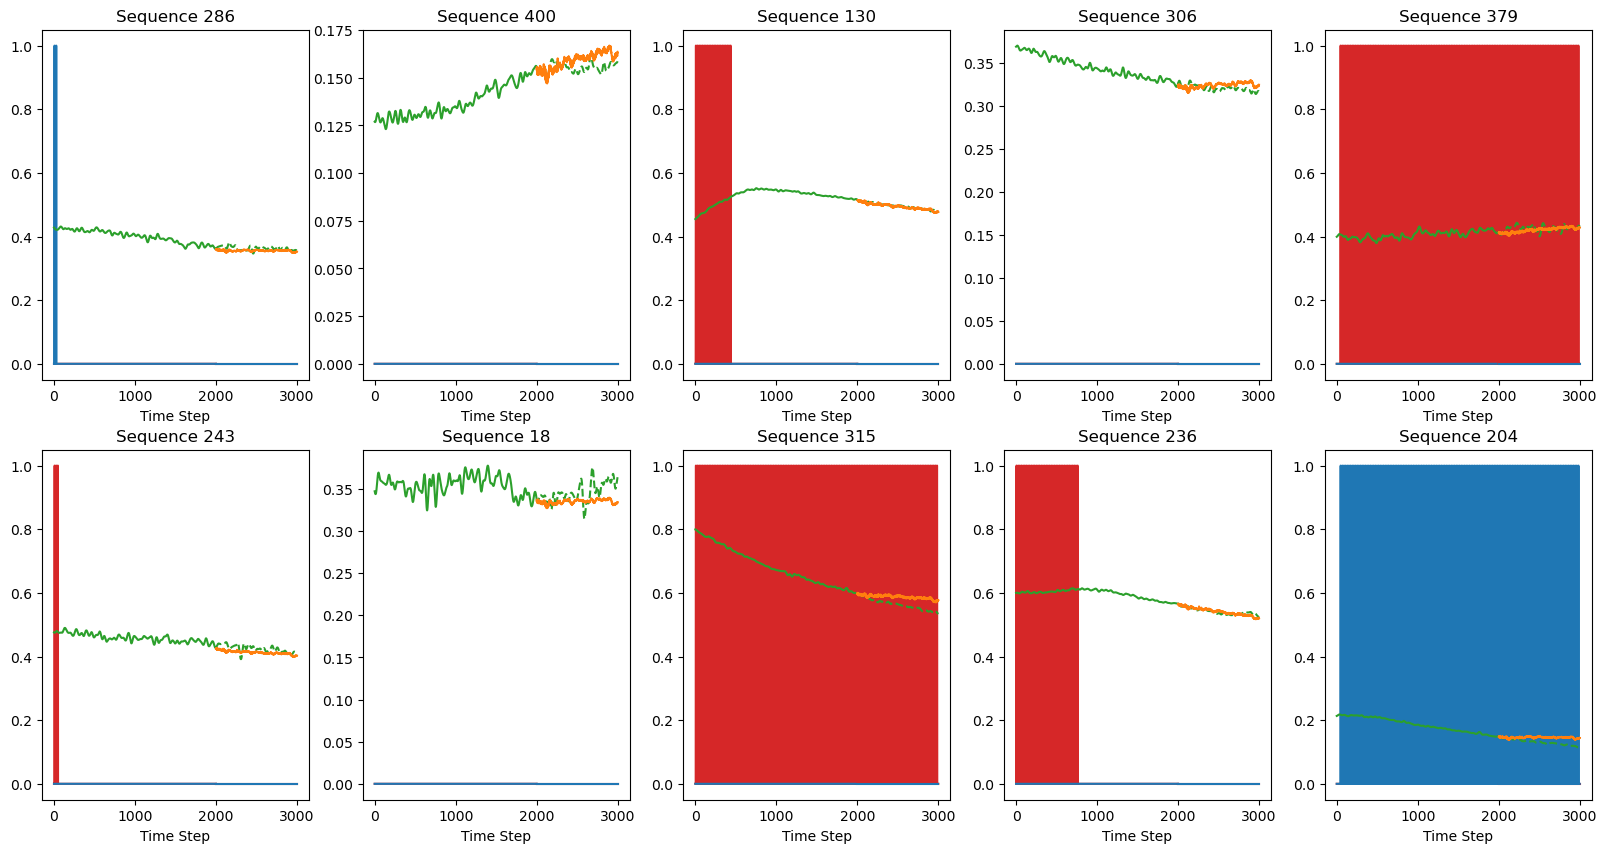

In [25]:
# Plot random 10 sequences with pulse events
pred_time = np.arange(X.shape[1],X.shape[1]+y.shape[1])

# Make model prediction
model.eval()
with torch.no_grad():
    test_predict = model(X_test.to(device))
test_predict = test_predict.cpu().numpy()

plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    random_idx = np.random.randint(0, X_test.shape[0])
    plt.plot(X_test[random_idx,:,0], color='tab:red')
    plt.plot(X_test[random_idx,:,1], color='tab:blue')
    plt.plot(X_test[random_idx,:,2], color='tab:green')
    
    # Plot model predicton
    plt.plot(pred_time, y_test_laser[random_idx,:,0], color='tab:red', linestyle='-')
    plt.plot(pred_time, y_test_laser[random_idx,:,1], color='tab:blue', linestyle='-')
    plt.plot(pred_time, y_test[random_idx], color='tab:green', linestyle='--')
    plt.plot(pred_time, test_predict[random_idx,:,0], color='tab:orange')
    
    plt.title(f'Sequence {random_idx}')
    plt.xlabel('Time Step')
plt.show()

In [19]:
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def simulate_input_data(red_laser, blue_laser, input_duration=0.5,
                        fs=10000, plot=False, stim_samples=500):
    simulate_samples = int(input_duration * fs)
    simulated_dopamine = np.random.randn(simulate_samples)
    simulated_red_laser = np.zeros(simulate_samples)
    simulated_blue_laser = np.zeros(simulate_samples)

    # Make red laser pulses (5 samples per pulse) in the last 100ms
    if red_laser:
        red_laser_start = simulate_samples - stim_samples
        for i in range(red_laser_start, simulate_samples,15):
            simulated_red_laser[i:i+5] = 1
        # add small ramp up of dopamine signal
        simulated_dopamine[red_laser_start:simulate_samples] += np.linspace(0, 1, stim_samples)
            

    if blue_laser:
        blue_laser_start = simulate_samples - stim_samples
        for i in range(blue_laser_start, simulate_samples,15):
            simulated_blue_laser[i:i+5] = 1
        # add small ramp up of dopamine signal
        simulated_dopamine[blue_laser_start:simulate_samples] -= np.linspace(0, 1, stim_samples)

    # low pass filter the dopamine signal
    cutoff = 200  # Cutoff frequency in Hz
    simulated_dopamine = lowpass_filter(simulated_dopamine.flatten(), cutoff, fs)

    if plot:
        plt.plot(simulated_dopamine, color='green')
        plt.plot(simulated_red_laser, color='red')
        plt.plot(simulated_blue_laser, color='blue')
        plt.show()

    return np.vstack((simulated_red_laser, simulated_blue_laser, simulated_dopamine)).T


In [20]:
# Feed in an artificial 500ms data sequence and predict the output
fs = 10000
input_duration = 0.1

# 1. Generate a random 500ms data sequence with no/red/blue laser pulse for last 100ms
fake_no_laser = simulate_input_data(red_laser=False, blue_laser=False, input_duration=input_duration, fs=fs, plot=False)
fake_no_laser_tensor = torch.from_numpy(fake_no_laser).float().unsqueeze(0)
fake_red_laser = simulate_input_data(red_laser=True, blue_laser=False, input_duration=input_duration, fs=fs, plot=False)
fake_red_laser_tensor = torch.from_numpy(fake_red_laser).float().unsqueeze(0)
fake_blue_laser = simulate_input_data(red_laser=False, blue_laser=True, input_duration=input_duration, fs=fs, plot=False)
fake_blue_laser_tensor = torch.from_numpy(fake_blue_laser).float().unsqueeze(0)

# 2. Predict the output for the future 500ms 
n_pred_samples = int(input_duration * fs)
pred_no_laser = torch.zeros((n_pred_samples, 1))
pred_red_laser = torch.zeros((n_pred_samples, 1))
pred_blue_laser = torch.zeros((n_pred_samples, 1))

model.eval()
with torch.no_grad():
    # Predict the output
    no_laser_pred = model(fake_no_laser_tensor.to(device)).cpu().numpy()
    red_laser_pred = model(fake_red_laser_tensor.to(device)).cpu().numpy()
    blue_laser_pred = model(fake_blue_laser_tensor.to(device)).cpu().numpy()

    # Store the predictions
    pred_no_laser = torch.from_numpy(no_laser_pred).squeeze()
    pred_red_laser = torch.from_numpy(red_laser_pred).squeeze()
    pred_blue_laser = torch.from_numpy(blue_laser_pred).squeeze()

    # for i in tqdm.tqdm(range(1)):
    #     # Predict the output
    #     no_laser_pred = model(fake_no_laser_tensor.to(device)).cpu().numpy()
    #     red_laser_pred = model(fake_red_laser_tensor.to(device)).cpu().numpy()
    #     blue_laser_pred = model(fake_blue_laser_tensor.to(device)).cpu().numpy()

    #     # No scaler: use prediction as-is
    #     no_laser_pred_orig = no_laser_pred
    #     red_laser_pred_orig = red_laser_pred
    #     blue_laser_pred_orig = blue_laser_pred

    #     # Store the predictions
    #     pred_no_laser = torch.from_numpy(no_laser_pred_orig)
    #     pred_red_laser = torch.from_numpy(red_laser_pred_orig)
    #     pred_blue_laser = torch.from_numpy(blue_laser_pred_orig)

    #     # shift the time step by 1 and add the new dopamine level
    #     new_sample = [0, 0, pred_no_laser[i].item()]  # Use .item() to get scalar value
    #     new_sample_tensor = torch.tensor(new_sample).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3)
    #     fake_no_laser_tensor = torch.cat((fake_no_laser_tensor[:, 1:, :], new_sample_tensor), dim=1)
    #     fake_red_laser_tensor = torch.cat((fake_red_laser_tensor[:, 1:, :], new_sample_tensor), dim=1)
    #     fake_blue_laser_tensor = torch.cat((fake_blue_laser_tensor[:, 1:, :], new_sample_tensor), dim=1)



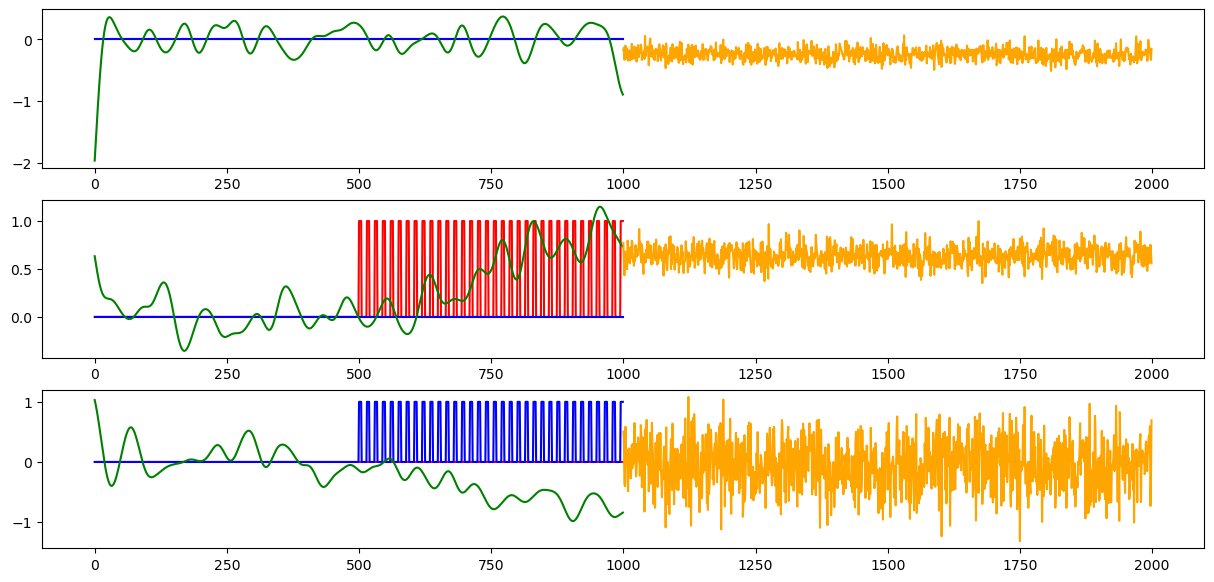

In [26]:
# 3. Plot the results
fig, axs = plt.subplots(3,1,figsize=(15, 7))

sim_pred_time = np.arange(fake_no_laser_tensor.shape[1],fake_no_laser_tensor.shape[1]+pred_no_laser.shape[0])

axs[0].plot(fake_no_laser[:,0], color='red')
axs[0].plot(fake_no_laser[:,1], color='blue')
axs[0].plot(fake_no_laser[:,2], color='green')
axs[0].plot(sim_pred_time, pred_no_laser, color='orange')

axs[1].plot(fake_red_laser[:,0], color='red')
axs[1].plot(fake_red_laser[:,1], color='blue')
axs[1].plot(fake_red_laser[:,2], color='green')
axs[1].plot(sim_pred_time, pred_red_laser, color='orange')

axs[2].plot(fake_blue_laser[:,0], color='red')
axs[2].plot(fake_blue_laser[:,1], color='blue')
axs[2].plot(fake_blue_laser[:,2], color='green')
axs[2].plot(sim_pred_time, pred_blue_laser, color='orange')

## Step 9: Save the model

In [ ]:
# Save the model
import os
from datetime import datetime

model_dir = "/n/holylabs/LABS/bsabatini_lab/Users/shunnnli/BrainClamp/models"

# Create models directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Get today's date as YYYY-MM-DD
today_str = datetime.today().strftime('%Y%m%d')
model_filename = f"models/TCN-{today_str}.pt"

# Save the PyTorch model's state_dict
torch.save(model.state_dict(), model_filename)

print(f"Model saved to {model_filename}")


In [ ]:
# Load the model
# model_filename = "/n/holylabs/LABS/bsabatini_lab/Users/shunnnli/BrainClamp/models/TCN-20251010.pt"

# Model parameters
input_size = X_train.shape[2]  # Number of features (3)
hidden_size = 128
num_layers = 8 
output_size = 1

# Create TCN model
model = TCNModel(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers,
    output_size=output_size, 
    kernel_size=3,  # TCN kernel size
    dropout=0.2
)

model.load_state_dict(torch.load(model_filename))